In [37]:
import os, os.path
import cv2
import random
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np



surprise_path = "../Lab1/Cohn-Kanade/surprise/"
happy_path = "../Lab1/Cohn-Kanade/happy/"

surprise_imgs = []
happy_imgs = []

images = os.listdir(surprise_path)
for img_num, img in enumerate(images):
    surprise_imgs.append(cv2.cvtColor(cv2.imread(surprise_path + '/' + img), cv2.COLOR_BGR2GRAY))

images = os.listdir(happy_path)
for img_num, img in enumerate(images):
    happy_imgs.append(cv2.cvtColor(cv2.imread(happy_path + '/' + img), cv2.COLOR_BGR2GRAY))

random.shuffle(surprise_imgs)
random.shuffle(happy_imgs)


X_train = surprise_imgs[:50] + happy_imgs[:50]
X_test = surprise_imgs[50:] + happy_imgs[50:]
y_train = [0] * 50 + [1] * 50
y_test = [0] * (len(surprise_imgs)-50) + [1] * (len(happy_imgs)-50)


twoD_to_vec = lambda mat: mat.reshape(-1).T
X_train_vectorized = list(map(twoD_to_vec, X_train))
X_test_vectorized = list(map(twoD_to_vec, X_test))


pca = decomposition.PCA(n_components=50)

X_train_pca = pca.fit_transform(X_train_vectorized)
X_test_pca = pca.transform(X_test_vectorized)


(1, 50)


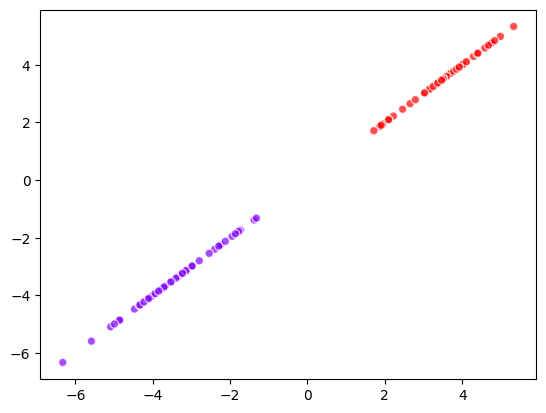

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
X_train_pca_lda = lda.fit_transform(X_train_pca, y_train)
X_test_pca_lda = lda.transform(X_test_pca)


plt.scatter(
    X_train_pca_lda[:,0],X_train_pca_lda[:,0],c=y_train,cmap='rainbow',alpha=0.7,edgecolors='w'
)
print(lda.scalings_.T.shape)

هرچند بردار «فیشر ال-دی-ای» بدست آمده در نتیجه این روش یک بردار 50 بعدی است، اما در تصویر فوق سعی کرده ایم به نحوی این تصویر شدن داده های دو کلاس بر روی 
بردار بدست آمده را نشان دهیم.

به این صورت که میدانیم به هرکدام از داده ها میشود ضریبی از بردار بدست آمده را نسبت داد که حاصلضرب آن عدد در آن بردار، تصویر آن داده روی بردار بدست آمده را نشان میدهد.

حال اگر این ضرایب را بر حسب خودشان ترسیم کنیم، در واقع به نوعی ضرایب تصویر شدن داده های هرکلاس روی بردار را روی یک بعد نشان داده ایم. 
تصویر فوق نیز همین است و چون دو دسته ضرایب داریم (ضرایب مربوط به سورپرایز و ضرایب مربوط به خوشحال) در نتیجه این پروجکشن دارای دو قسمت مجزا میشود.

(1, 600, 300)


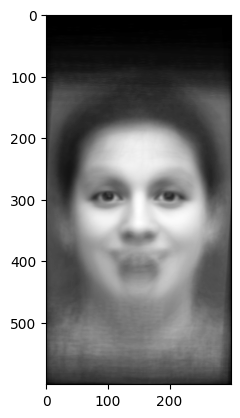

In [39]:
reconstraced_pca = pca.inverse_transform(lda.scalings_.T)
reconstraced_img = reconstraced_pca.reshape(reconstraced_pca.shape[0], X_train[0].shape[0], X_train[0].shape[1])
plt.imshow(reconstraced_img[0], cmap = 'gray')
print(reconstraced_img.shape)

نتیجه پرینت شده در سل قبل و دو سل قبل، اندازه نتایج تبدیل «ال-دی-ای» و تبدیل وارون آن برای تبدیل به تصویر عادی است.
که هر دو نشان دهنده این است که نتیجه «ال-دی-ای» تنها دارای یک بردار ویژه است. این مطابق انتظار است چرا که کلا دو کلاس از داده ها در دسترس بوده است.

همانطور که از تصویر واضح است، نواحی با تیرگی و مخدوشیت بیشتر مربوط به نقاطی از صورت هستند که در حالت «سورپرایز» نسبت به حالت «خوشحال» تفاوت جدی دارند.
در نتیجه این تفاوت، پراکندگی ناشی از این قسمت ها میان کلاس ها بیشتر بوده و در تصویری که خروجی خواهد بود اینگونه شده اند.

در نقطه مقابل، قسمت های روشن نواحی هستند که در هر دو حالت صورت شباهت و نزدیکی زیادی دارند و دارای پراکندگی کم هستند و در بردار بدست آمده از فیشر 
باقی میمانند. 




In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

svc_model = SVC()

Train_acc_knn1 = []
Test_acc_knn1 = []
Train_acc_knn3 = []
Test_acc_knn3 = []
Train_acc_knn5 = []
Test_acc_knn5 = []

Train_acc_lda = []
Test_acc_lda  = []

for n_c in range(5,50,5):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_vectorized)
    X_test = scaler.transform(X_test_vectorized)

    pca = decomposition.PCA(n_components = n_c)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lda = LinearDiscriminantAnalysis()
    X_train_pca_lda = lda.fit_transform(X_train_pca, y_train)
    X_test_pca_lda = lda.transform(X_test_pca)

    svc_model.fit(X_train_pca_lda, y_train)

    y_train_lda_pred = svc_model.predict(X_train_pca_lda)
    y_test_lda_pred = svc_model.predict(X_test_pca_lda)
    
    train_acc_lda = 100*(1 - sum(abs(y_train - y_train_lda_pred))/len(y_train))
    test_acc_lda  = 100*(1 - sum(abs(y_test - y_test_lda_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 1)
    est.fit(X_train_pca, y_train)
    y_train_knn1_pred = est.predict(X_train_pca)
    y_test_knn1_pred = est.predict(X_test_pca)
    train_acc_knn1 = 100*(1 - sum(abs(y_train - y_train_knn1_pred))/len(y_train))
    test_acc_knn1  = 100*(1 - sum(abs(y_test - y_test_knn1_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 3)
    est.fit(X_train_pca, y_train)
    y_train_knn3_pred = est.predict(X_train_pca)
    y_test_knn3_pred = est.predict(X_test_pca)
    train_acc_knn3 = 100*(1 - sum(abs(y_train - y_train_knn3_pred))/len(y_train))
    test_acc_knn3  = 100*(1 - sum(abs(y_test - y_test_knn3_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 5)
    est.fit(X_train_pca, y_train)
    y_train_knn5_pred = est.predict(X_train_pca)
    y_test_knn5_pred = est.predict(X_test_pca)
    train_acc_knn5 = 100*(1 - sum(abs(y_train - y_train_knn5_pred))/len(y_train))
    test_acc_knn5  = 100*(1 - sum(abs(y_test - y_test_knn5_pred))/len(y_test))

    print(f"for n_components = {n_c}:   Train_lda={train_acc_lda:.{3}f}%   Test_lda={test_acc_lda:.{3}f}%   Train_knn1={train_acc_knn1:.{3}f}%   Test_knn1={test_acc_knn1:.{3}f}%   Train_knn3={train_acc_knn3:.{3}f}%   Test_knn3={test_acc_knn3:.{3}f}%   Train_knn5={train_acc_knn5:.{3}f}%   Test_knn5={test_acc_knn5:.{3}f}%")
    Train_acc_lda.append(train_acc_lda)
    Test_acc_lda.append(test_acc_lda)
    Train_acc_knn1.append(train_acc_knn1)
    Test_acc_knn1.append(test_acc_knn1)
    Train_acc_knn3.append(train_acc_knn3)
    Test_acc_knn3.append(test_acc_knn3)
    Train_acc_knn5.append(train_acc_knn5)
    Test_acc_knn5.append(test_acc_knn5)


    


for n_components = 5:   Train_lda=64.000%   Test_lda=61.644%   Train_knn1=100.000%   Test_knn1=36.986%   Train_knn3=71.000%   Test_knn3=46.575%   Train_knn5=64.000%   Test_knn5=56.164%
for n_components = 10:   Train_lda=99.000%   Test_lda=86.301%   Train_knn1=100.000%   Test_knn1=53.425%   Train_knn3=86.000%   Test_knn3=67.123%   Train_knn5=85.000%   Test_knn5=76.712%
for n_components = 15:   Train_lda=97.000%   Test_lda=90.411%   Train_knn1=100.000%   Test_knn1=50.685%   Train_knn3=87.000%   Test_knn3=65.753%   Train_knn5=84.000%   Test_knn5=68.493%
for n_components = 20:   Train_lda=99.000%   Test_lda=95.890%   Train_knn1=100.000%   Test_knn1=49.315%   Train_knn3=89.000%   Test_knn3=65.753%   Train_knn5=83.000%   Test_knn5=73.973%
for n_components = 25:   Train_lda=99.000%   Test_lda=95.890%   Train_knn1=100.000%   Test_knn1=47.945%   Train_knn3=85.000%   Test_knn3=65.753%   Train_knn5=83.000%   Test_knn5=72.603%
for n_components = 30:   Train_lda=100.000%   Test_lda=95.890%   Train_

واضح است که با افزایش کامپوننت های «پی-سی-ای» دقت مدل هم در داده های آموزش هم در داده های تست افزایش میابد تا جایی که حتی به صد در صد هم میرسید. اما در مقابل، دقت «کی-ان-ان» از مقداری به بعد به قولی اشباع میشود و درصد دقت پایین تری نسبت به «ال-دی-ای» همواره دارد..

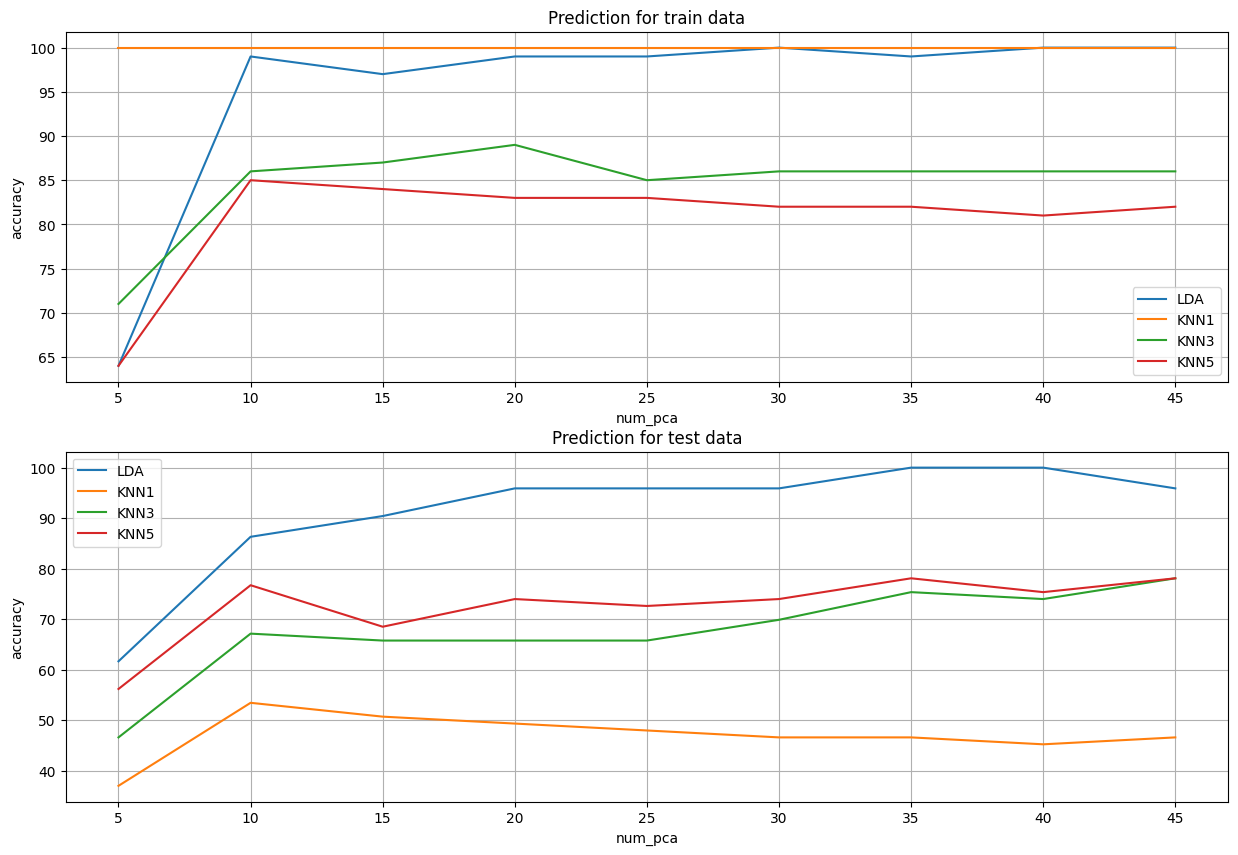

In [41]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(5,50,5),Train_acc_lda)
plt.plot(range(5,50,5),Train_acc_knn1)
plt.plot(range(5,50,5),Train_acc_knn3)
plt.plot(range(5,50,5),Train_acc_knn5)
plt.title("Prediction for train data")
plt.legend(["LDA","KNN1","KNN3","KNN5"])
plt.xlabel("num_pca")
plt.ylabel("accuracy")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(range(5,50,5),Test_acc_lda)
plt.plot(range(5,50,5),Test_acc_knn1)
plt.plot(range(5,50,5),Test_acc_knn3)
plt.plot(range(5,50,5),Test_acc_knn5)
plt.title("Prediction for test data")
plt.legend(["LDA","KNN1","KNN3","KNN5"])
plt.xlabel("num_pca")
plt.ylabel("accuracy")
plt.grid(True)